#                                                                             Macro-Scale Simulation

In [ ]:
import matplotlib.tri as tri
from matplotlib.collections import PolyCollection
from scipy.interpolate import griddata
import os
from fenics import plot
import meshio
import gmsh
import sys
from dolfin import *
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt


# Smart Adaptive MESH 

In [2]:

class FiberCompositeMeshGenerator:
    def __init__(self, H=1.0, W=3,lc=1):
        self.W = W #   meter Domain size
        self.H = H 
        self.lc = lc # Mesh resolution (Balance between accuracy and condition number)
       
        
        

    def generate(self):

        gmsh.initialize()
        gmsh.model.add("Composite_Panel")
        occ = gmsh.model.occ

        # 1. Define Dimensions
        S_size = 0.2
        source_x = 1.4
        source_y = 0.2
        
        # Calculate expected center for identification later
        expected_center = (source_x + S_size/2, source_y + S_size/2)

        # 2. Create Geometry
        rectangular = occ.addRectangle(0, 0, 0, self.W, self.H)
        source_square = occ.addRectangle(source_x, source_y, 0, S_size, S_size)

        # 3. Stitch them together
        # Fragment ensures the mesh is connected at the interface
        occ.fragment([(2, rectangular)], [(2, source_square)])
        occ.synchronize()

        # 4. Identification Loop
        source_surface = []
        panel_surface = []

        for surface in gmsh.model.getEntities(2):
            # com = [x, y, z]
            com = occ.getCenterOfMass(surface[0], surface[1])
            
            
            if abs(com[0] - expected_center[0]) < 1e-3 and \
               abs(com[1] - expected_center[1]) < 1e-3:
                source_surface.append(surface[1])
                print(f"-> Found Source Square at {com[0], com[1]}")
            else:
                panel_surface.append(surface[1])

        # 5. Assign Physical Groups
        gmsh.model.addPhysicalGroup(2, source_surface, tag=1, name="Source")
        gmsh.model.addPhysicalGroup(2, panel_surface, tag=2, name="Panel")

        # label the Top and Bottom edges for a thermal gradient
        # Identify and Tag Boundary Edges ---
        left_edges = []
        right_edges = []
        top_edges = []
        bottom_edges = []
        source_interface = []
        # Get all 1D entities (curves/lines)
        for edge in gmsh.model.getEntities(1):
            bounds = gmsh.model.getBoundingBox(edge[0], edge[1])
            xmin, ymin, xmax, ymax = bounds[0], bounds[1], bounds[3], bounds[4]

            # Left Edge: x=0
            if abs(xmin) < 1e-6 and abs(xmax) < 1e-6:
                left_edges.append(edge[1])
            # Right Edge: x is W 
            elif abs(xmin - self.W) < 1e-6 and abs(xmax - self.W) < 1e-6:
                right_edges.append(edge[1])
            # Bottom Edge: y is 0
            elif abs(ymin) < 1e-6 and abs(ymax) < 1e-6:
                bottom_edges.append(edge[1])
            # Top Edge: y is H (1.0)
            elif abs(ymin - self.H) < 1e-6 and abs(ymax - self.H) < 1e-6:
                top_edges.append(edge[1])
            else:
                # These are the 4 lines forming the source square
                source_interface.append(edge[1])

        # Assign Physical Groups with macro-relevant names
        gmsh.model.addPhysicalGroup(1, left_edges, tag=10, name="Left_Side")
        gmsh.model.addPhysicalGroup(1, right_edges, tag=11, name="Right_Side")
        gmsh.model.addPhysicalGroup(1, top_edges, tag=12, name="Radiator_Top")
        gmsh.model.addPhysicalGroup(1, bottom_edges, tag=13, name="Bottom_Side")
        gmsh.model.addPhysicalGroup(1, source_interface, tag=20, name="Source_Boundary")

        # Local Mesh Refinement (Fields) ---
# FIELD 1: Distance to the Source Square edges
        f1 = gmsh.model.mesh.field.add("Distance")
        gmsh.model.mesh.field.setNumbers(f1, "CurvesList", source_interface)

        # FIELD 2: Threshold (Transition from chip to panel)
        f2 = gmsh.model.mesh.field.add("Threshold")
        gmsh.model.mesh.field.setNumber(f2, "InField", f1)
        gmsh.model.mesh.field.setNumber(f2, "SizeMin", self.lc / 4) # Small near chip
        gmsh.model.mesh.field.setNumber(f2, "SizeMax", self.lc)     # Normal in panel
        gmsh.model.mesh.field.setNumber(f2, "DistMin", S_size * 0.1) 
        gmsh.model.mesh.field.setNumber(f2, "DistMax", S_size * 0.5) 

        # FIELD 3: Constant (Ensures small mesh INSIDE the chip)
        f3 = gmsh.model.mesh.field.add("Constant") 
        gmsh.model.mesh.field.setNumbers(f3, "SurfacesList", source_surface)
        gmsh.model.mesh.field.setNumber(f3, "VIn", self.lc / 4) #inside value

        # FIELD 4: Min (Combine them)
        f_min = gmsh.model.mesh.field.add("Min")
        gmsh.model.mesh.field.setNumbers(f_min, "FieldsList", [f2, f3])
        gmsh.model.mesh.field.setAsBackgroundMesh(f_min)

        # FIELD 4: Min - Combines f2 (matrix transition) and f3 (fiber interior)
        # It tells Gmsh: "At any point, use the SMALLEST size from either Field 2 or Field 3"
        f_min = gmsh.model.mesh.field.add("Min")
        gmsh.model.mesh.field.setNumbers(f_min, "FieldsList", [f2, f3])

        # Activate the refinement using the combined logic
        gmsh.model.mesh.field.setAsBackgroundMesh(f_min) #this combines both fields so that we have fine mesh near fiber edges and also fine mesh inside fibers. Check f2 and f3 for details. 

        # Disable default settings that might override our fields
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)

        # Generate  
        gmsh.model.mesh.generate(2)
        gmsh.write("Composite_panel.msh")

        if '-nopopup' not in sys.argv:
            gmsh.fltk.run()

        gmsh.finalize()

# Main For the MESH

In [3]:
H=1.0  # Domain size in meters
W=3  # Initial fiber radius in meters
lc=0.005  # Mesh resolution
MeshGenerator = FiberCompositeMeshGenerator(H=H, W=W,lc=lc) 
MeshGenerator.generate()

-> Found Source Square at (1.4999999999999998, 0.30000000000000004)                                                                 
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00182684s, CPU 0.000872s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 8.77811s, CPU 9.05245s)
Info    : 191458 nodes 383562 elements
Info    : Writing 'Composite_panel.msh'...
Info    : Done writing 'Composite_panel.msh'
-------------------------------------------------------
Version       : 4.15.0
License       : GNU General Public License
Build OS    

# Converting File for Feneics

In [4]:

# Read mesh
msh = meshio.read("Composite_panel.msh")
points = msh.points[:, :2]  # 2D

# --- Mesh (geometry) ---
triangles = msh.cells_dict["triangle"]
meshio.write("mesh.xdmf", meshio.Mesh(points=points, cells={"triangle": triangles}))

# --- Cell markers (subdomains) ---
cell_data = msh.cell_data_dict["gmsh:physical"]["triangle"]
meshio.write(
    "subdomains.xdmf",
    meshio.Mesh(points=points, cells={"triangle": triangles}, cell_data={"subdomains": [cell_data]})
)

# --- Facet markers (boundaries) ---
if "line" in msh.cells_dict:
    lines = msh.cells_dict["line"]
    facet_data = msh.cell_data_dict["gmsh:physical"]["line"] #nested dictionary 
    meshio.write(
        "boundaries.xdmf",
        meshio.Mesh(points=points, cells={"line": lines}, cell_data={"boundaries": [facet_data]}) 
    )
else:
    print("No boundary lines found.")

# Macroscopic Solving of Heat Equation 

In [5]:
from dolfin import solve


class PanelSolver:
    def __init__(self, W=3.0, H=1.0, k_xx=100.0, k_xy=0.0, k_yy=5.0, Q=50.0):
        self.W = W       # Panel Width
        self.H = H       # Panel Height
        self.k_xx = k_xx
        self.k_xy = k_xy
        self.k_yy = k_yy
        self.Q = Q       # Heat Source Strength (W/m^2)

    def solve(self):
        #  Calculate Rotated Tensor Components
        k_xx = self.k_xx
        k_xy = self.k_xy
        k_yy = self.k_yy

       

        # Load Mesh and Markers
        mesh = Mesh()
        with XDMFFile("mesh.xdmf") as f:
            f.read(mesh)
        
        mvc = MeshValueCollection("size_t", mesh, 2)
        with XDMFFile("subdomains.xdmf") as f:
            f.read(mvc, "subdomains")
        cell_markers = MeshFunction("size_t", mesh, mvc)

        # Define the Anisotropic Conductivity (K)
        # Since the whole panel is the same composite, K is uniform
        K = as_tensor([[k_xx, k_xy], [k_xy, k_yy]])

        # Define Function Space and Measures
        V = FunctionSpace(mesh, "CG", 1)
        dx = Measure('dx', domain=mesh, subdomain_data=cell_markers)

        # Boundary Conditions (The Radiator)
        # Set Top edge to 0 degrees
        bc_top = DirichletBC(V, Constant(0.0), f"near(x[1], {self.H}) && on_boundary")
        
        # Variational Problem
        u = TrialFunction(V)
        v = TestFunction(V)
        
        # Left side: Diffusion (Heat conduction)
        a = inner(K * grad(u), grad(v)) * dx(1) + inner(K * grad(u), grad(v)) * dx(2)        
        # Right side: Heat Generation (Only in Source Square: Tag 1)
        L = Constant(self.Q) * v * dx(1)

        # Solve
        u_sol = Function(V)
        solve(a == L, u_sol, bc_top, solver_parameters={"linear_solver": "cg", "preconditioner": "hypre_amg"})
        return u_sol

# Main for the Panel

In [6]:
runner = PanelSolver(W=W, H=H, k_xx=2.2098, k_xy=0.0428, k_yy=1.7092, Q=10000)
solution = runner.solve()


Solving linear variational problem.


# Max Temperature At the Top vs Tilting Fibers

--- Running Simulation for Angle: 0° ---
Solving linear variational problem.


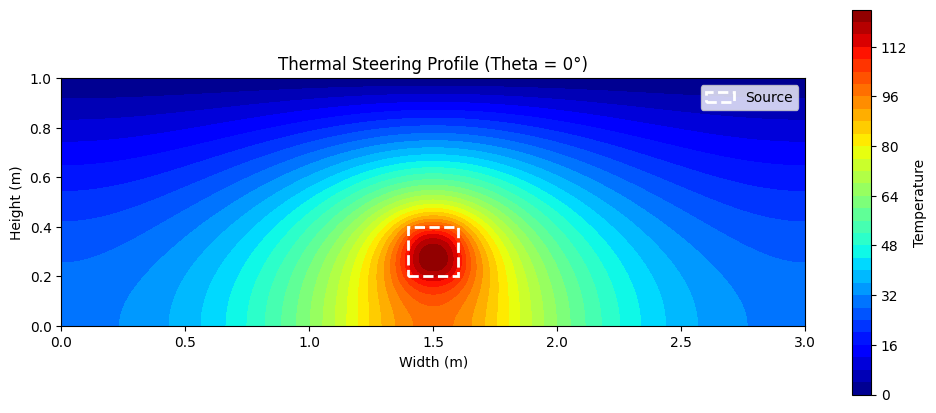

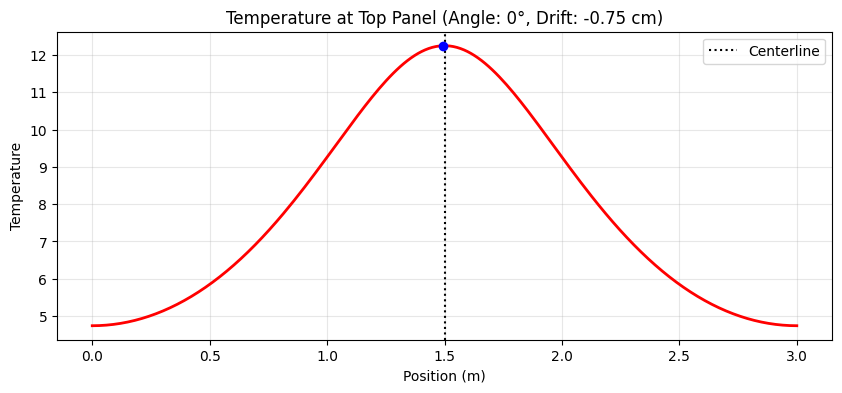

Angle 0° Result: Max T: 12.25, Drift: -0.75 cm
------------------------------
--- Running Simulation for Angle: 10° ---
Solving linear variational problem.


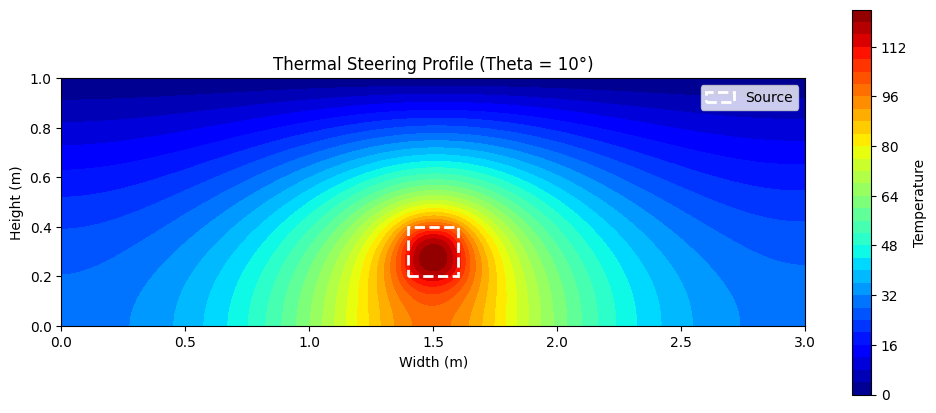

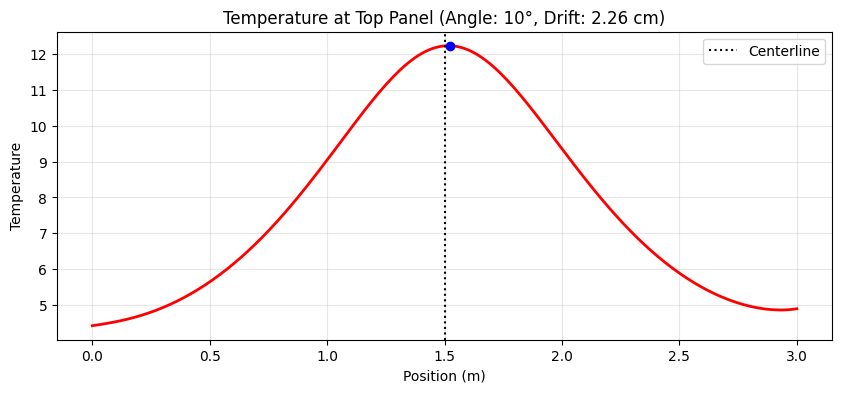

Angle 10° Result: Max T: 12.23, Drift: 2.26 cm
------------------------------
--- Running Simulation for Angle: 20° ---
Solving linear variational problem.


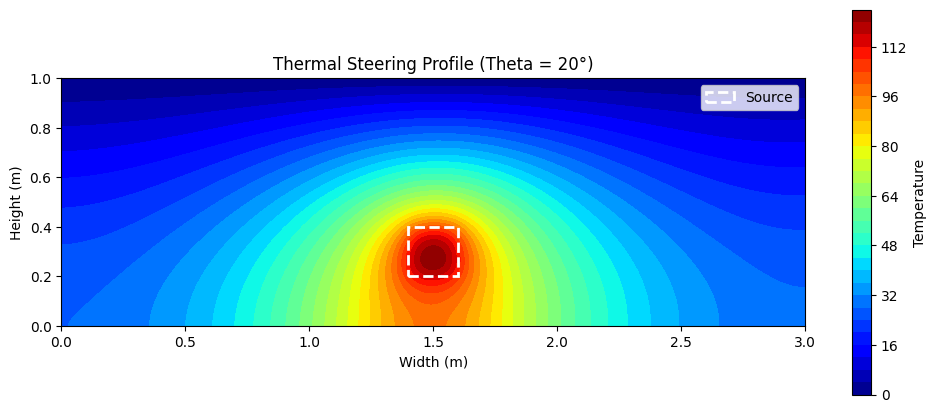

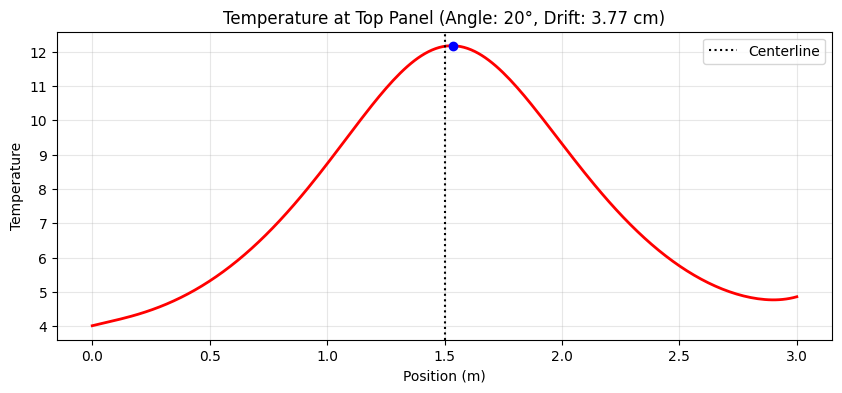

Angle 20° Result: Max T: 12.18, Drift: 3.77 cm
------------------------------
--- Running Simulation for Angle: 30° ---
Solving linear variational problem.


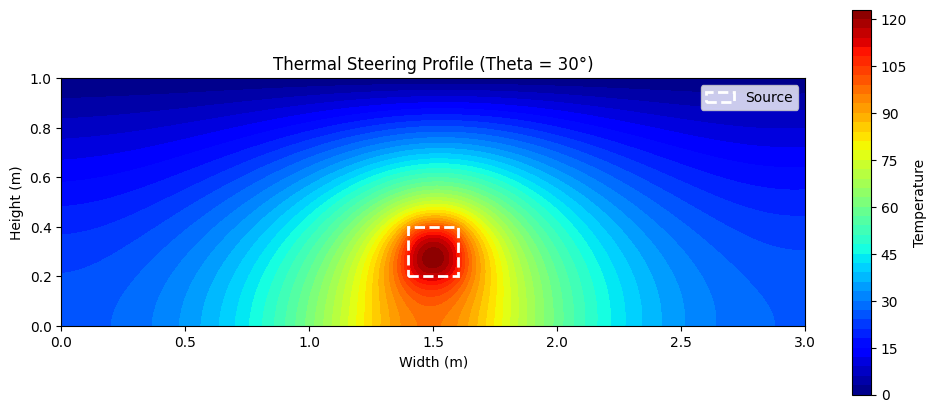

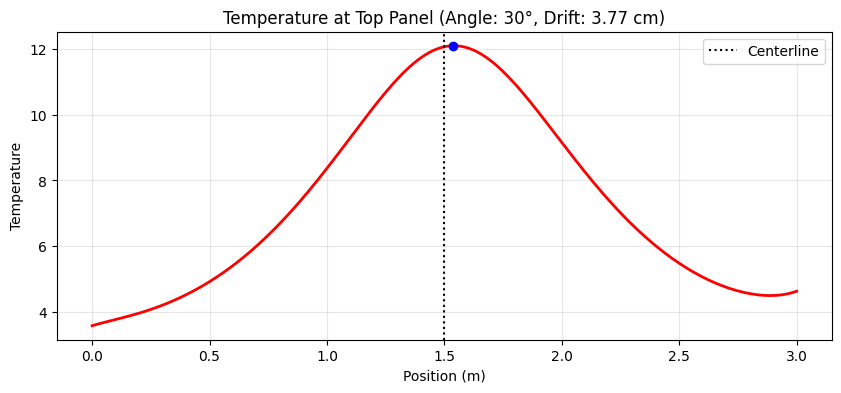

Angle 30° Result: Max T: 12.10, Drift: 3.77 cm
------------------------------
--- Running Simulation for Angle: 40° ---
Solving linear variational problem.


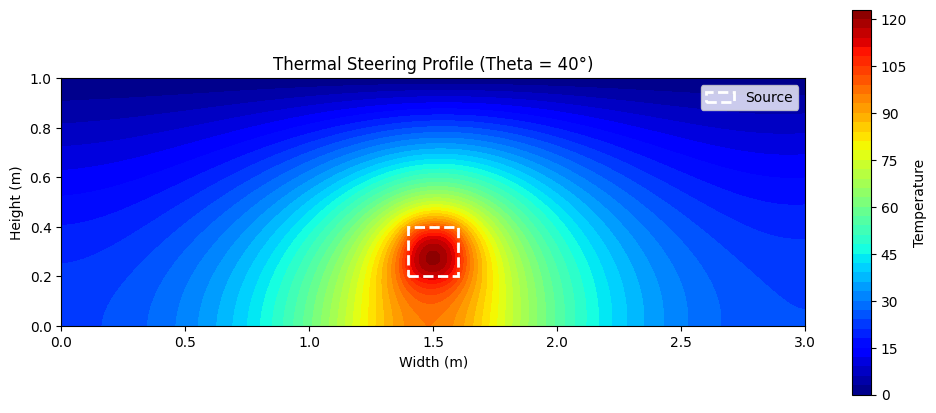

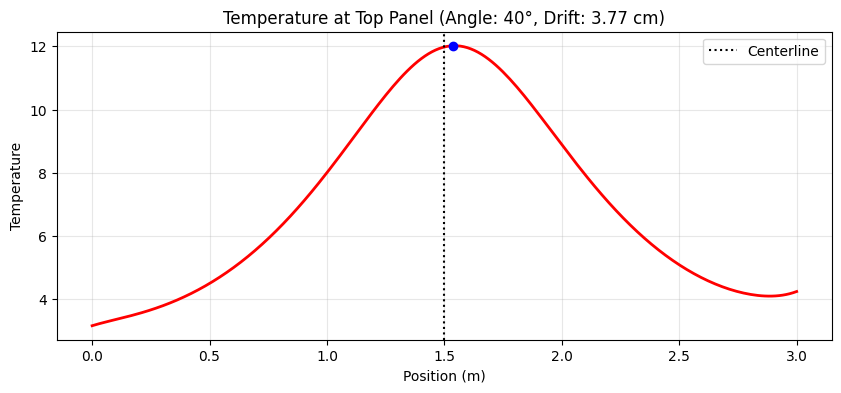

Angle 40° Result: Max T: 12.02, Drift: 3.77 cm
------------------------------
--- Running Simulation for Angle: 50° ---
Solving linear variational problem.


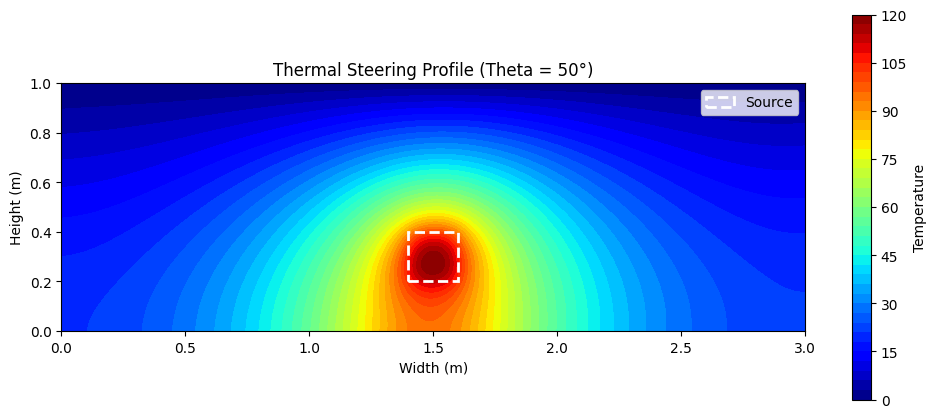

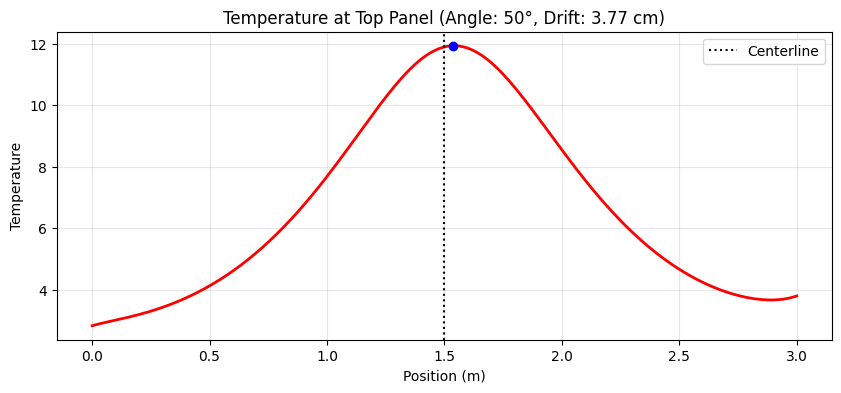

Angle 50° Result: Max T: 11.94, Drift: 3.77 cm
------------------------------
--- Running Simulation for Angle: 60° ---
Solving linear variational problem.


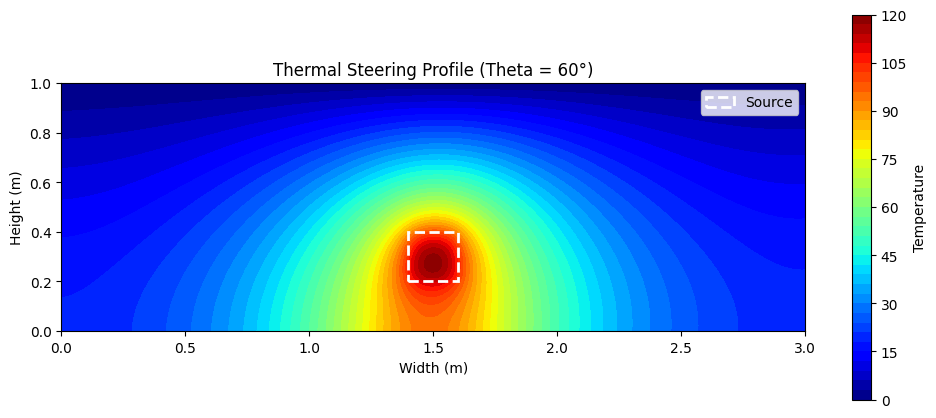

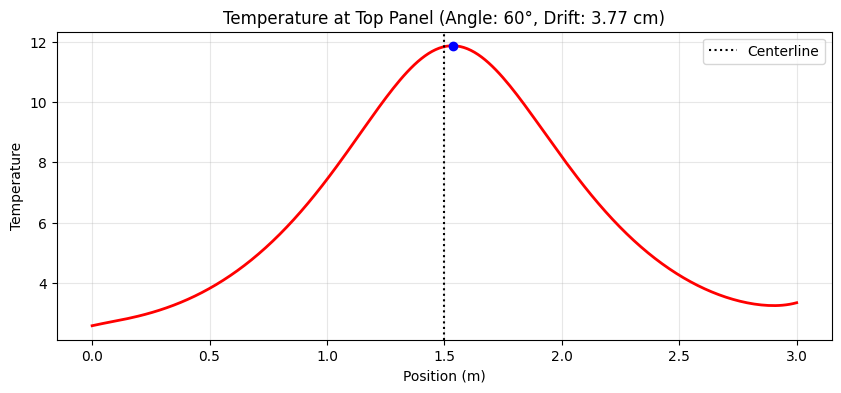

Angle 60° Result: Max T: 11.87, Drift: 3.77 cm
------------------------------
--- Running Simulation for Angle: 70° ---
Solving linear variational problem.


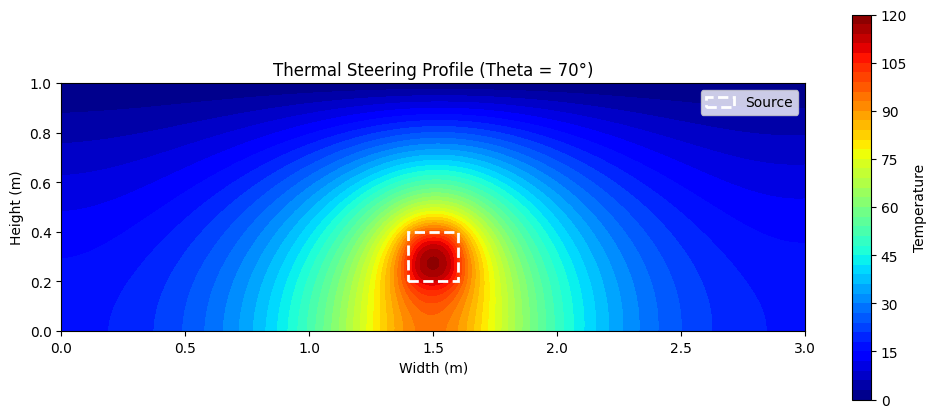

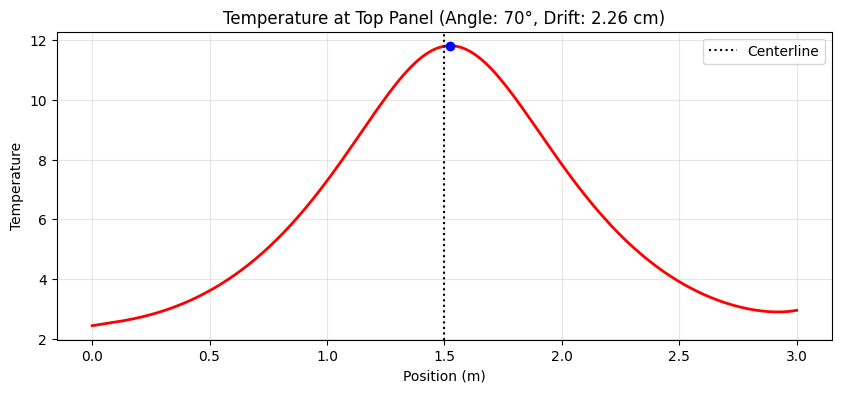

Angle 70° Result: Max T: 11.81, Drift: 2.26 cm
------------------------------
--- Running Simulation for Angle: 80° ---
Solving linear variational problem.


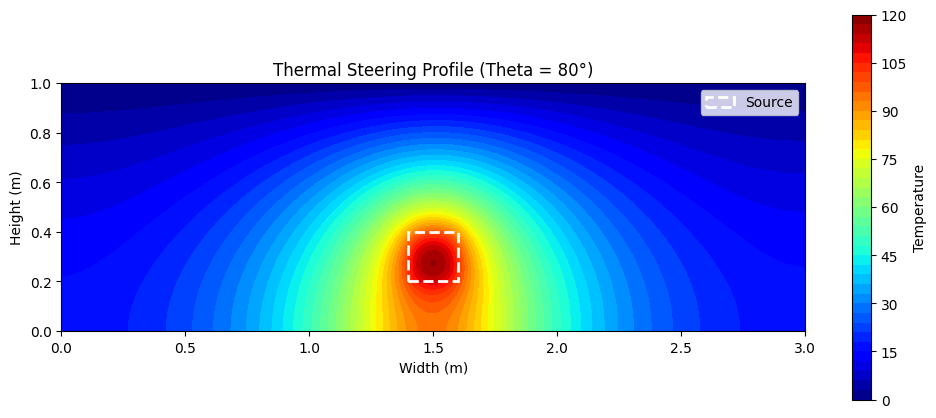

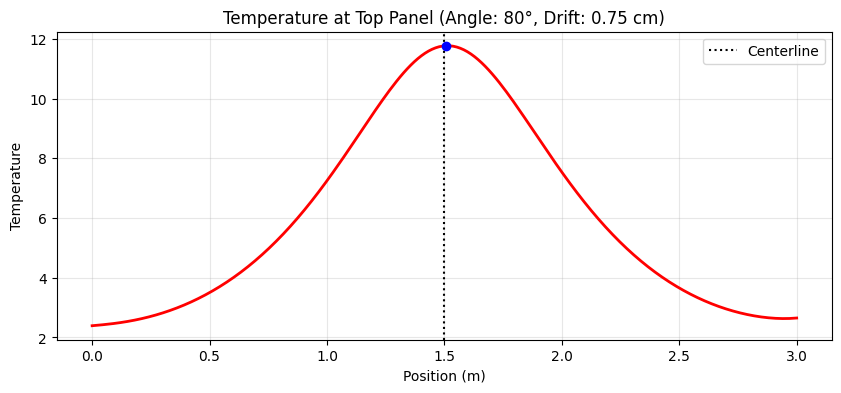

Angle 80° Result: Max T: 11.77, Drift: 0.75 cm
------------------------------
--- Running Simulation for Angle: 90° ---
Solving linear variational problem.


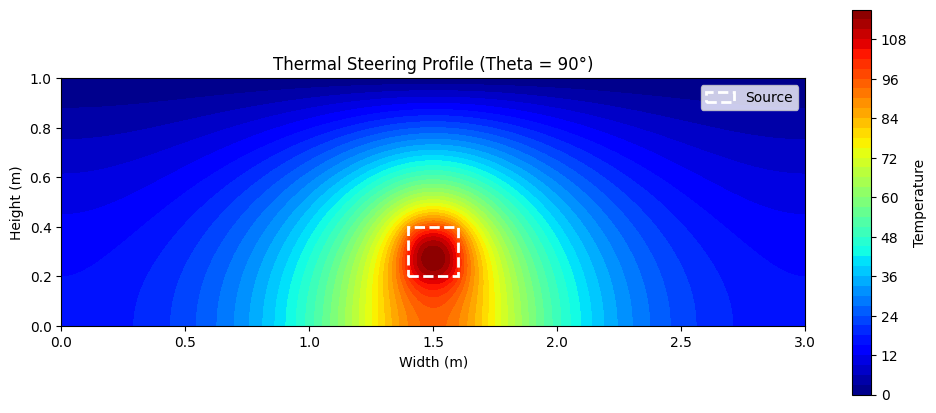

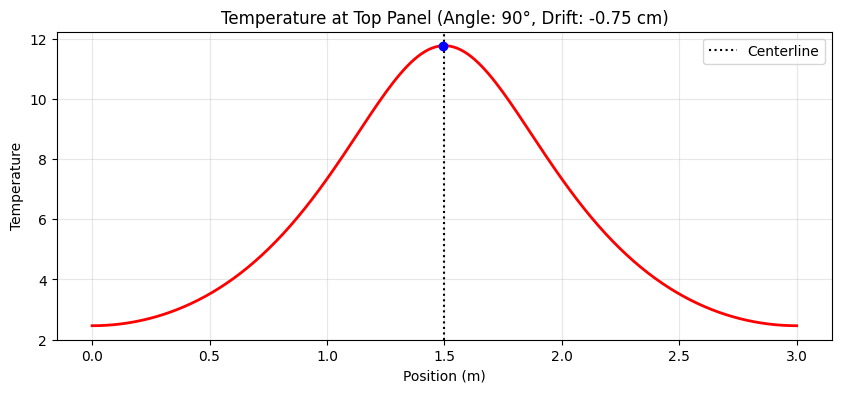

Angle 90° Result: Max T: 11.76, Drift: -0.75 cm
------------------------------


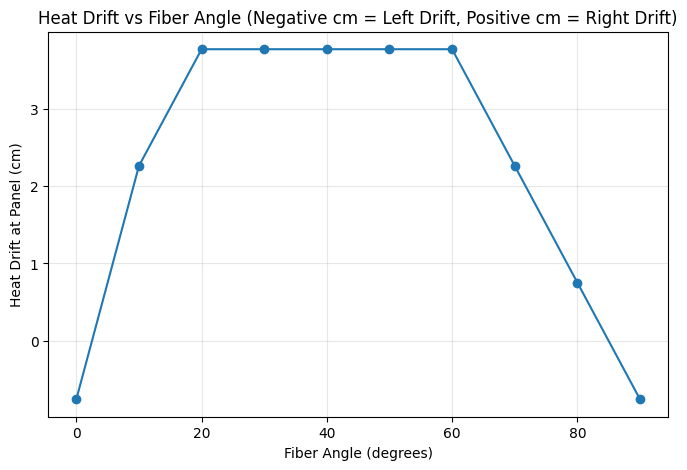

In [8]:


# Load the data from your first notebook
data = np.load("composite_data.npz")
angles = data['angles']
k_xx_list = data['k_xx']
k_xy_list = data['k_xy']
k_yy_list = data['k_yy']
drif_list = []

for th, xx, xy, yy in zip(angles, k_xx_list, k_xy_list, k_yy_list):
    print(f"--- Running Simulation for Angle: {th}° ---")
    
    # SOLVE
    runner = PanelSolver(W=W, H=H, k_xx=xx, k_xy=xy, k_yy=yy, Q=10000)
    solution = runner.solve()
    solution.set_allow_extrapolation(True) # Prevents the crash!

    # 2D HEATMAP
    plt.figure(figsize=(12, 5))
    p = plot(solution, title=f"Thermal Steering Profile (Theta = {th}°)", cmap="jet")
    plt.colorbar(p, label='Temperature')

    # Draw the Heat Source Square
    plt.gca().add_patch(plt.Rectangle((1.4, 0.2), 0.2, 0.2, 
                                     edgecolor='white', fill=False, lw=2, ls='--', label="Source"))
    plt.xlabel("Width (m)")
    plt.ylabel("Height (m)")
    plt.legend()
    plt.show() 

    # 1D CROSS-SECTION
    x_line = np.linspace(0, runner.W, 200)
    temp_line = [solution(x, runner.H*0.90) for x in x_line]
    
    # Peak and Drift Calculations
    max_temp = max(temp_line)
    max_x = x_line[np.argmax(temp_line)]
    drift = max_x - 1.5
    drif_list.append(drift)  # Store drift in cm 
    
    plt.figure(figsize=(10, 4))
    plt.plot(x_line, temp_line, color='red', linewidth=2)
    plt.axvline(x=1.5, color='black', linestyle=':', label='Centerline')
    plt.scatter(max_x, max_temp, color='blue', zorder=5)
    plt.title(f"Temperature at Top Panel (Angle: {th}°, Drift: {drift*100:.2f} cm)")
    plt.xlabel("Position (m)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show() # This MUST be inside the loop!

    print(f"Angle {th}° Result: Max T: {max_temp:.2f}, Drift: {drift*100:.2f} cm")
    print("-" * 30)
# Final Drift Summary
fig=plt.figure(figsize=(8,5))
plt.plot(angles, np.array(drif_list)*100, marker='o')
plt.title("Heat Drift vs Fiber Angle (Negative cm = Left Drift, Positive cm = Right Drift)")
plt.xlabel("Fiber Angle (degrees)")
plt.ylabel("Heat Drift at Panel (cm)")
plt.grid(alpha=0.3)
plt.show()    

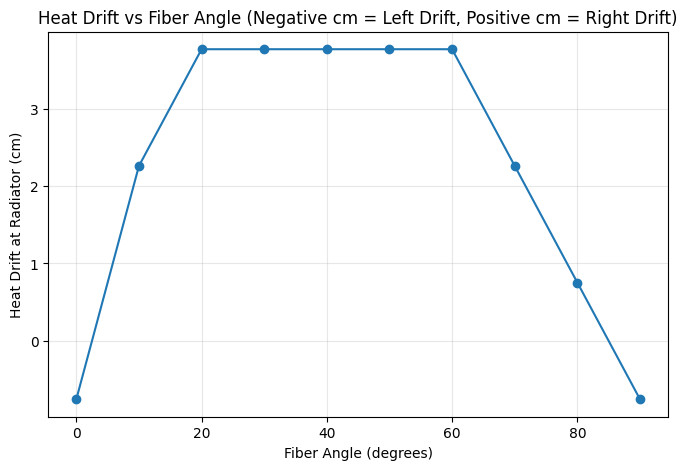

In [9]:
fig=plt.figure(figsize=(8,5))
plt.plot(angles, np.array(drif_list)*100, marker='o')
plt.title("Heat Drift vs Fiber Angle (Negative cm = Left Drift, Positive cm = Right Drift)")
plt.xlabel("Fiber Angle (degrees)")
plt.ylabel("Heat Drift at Radiator (cm)")
plt.grid(alpha=0.3)
plt.show()    

#  Min Temperature At the Top vs Tilting Fibers

--- Running Simulation for Angle: 0° ---
Solving linear variational problem.


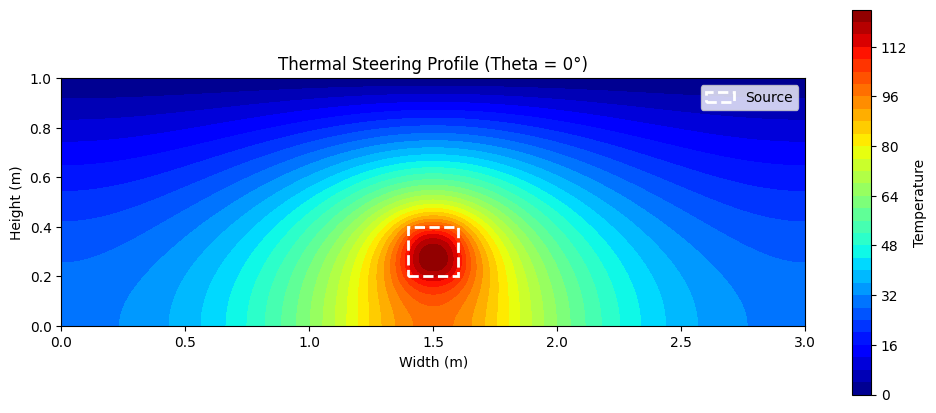

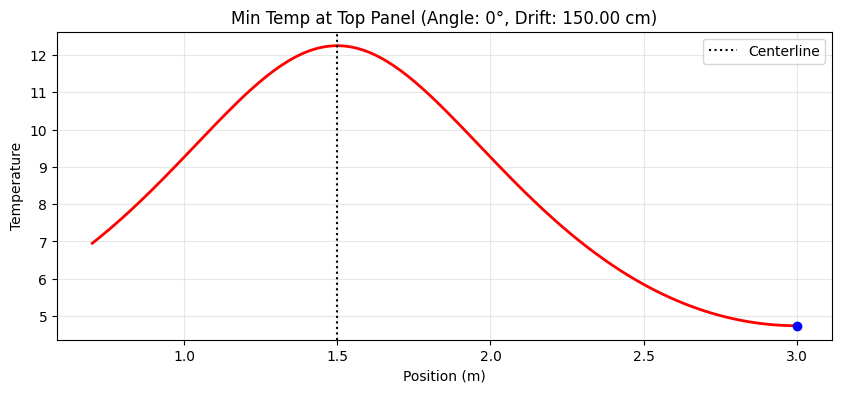

Angle 0° Result: Min T: 4.74, Drift: 150.00 cm
------------------------------
--- Running Simulation for Angle: 10° ---
Solving linear variational problem.


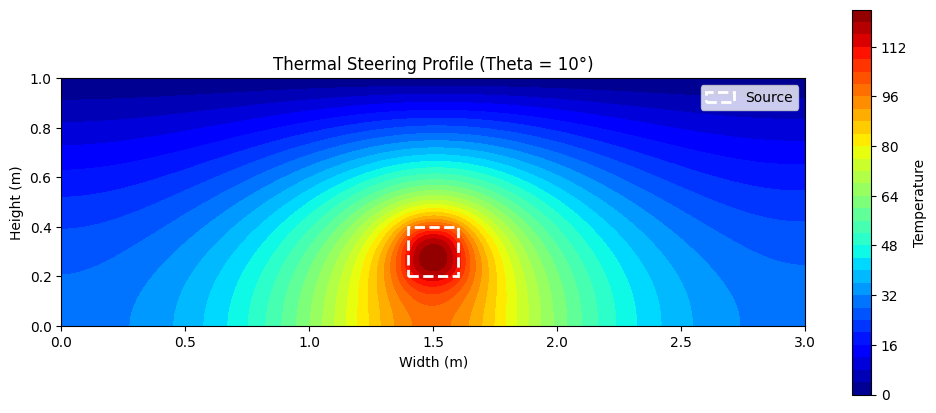

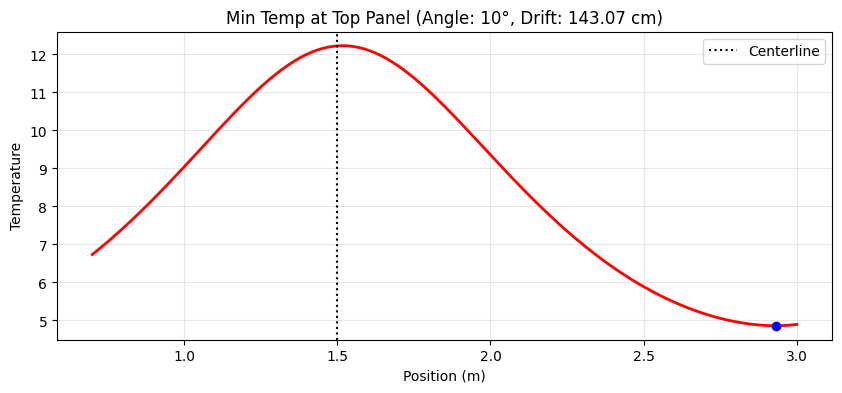

Angle 10° Result: Min T: 4.86, Drift: 143.07 cm
------------------------------
--- Running Simulation for Angle: 20° ---
Solving linear variational problem.


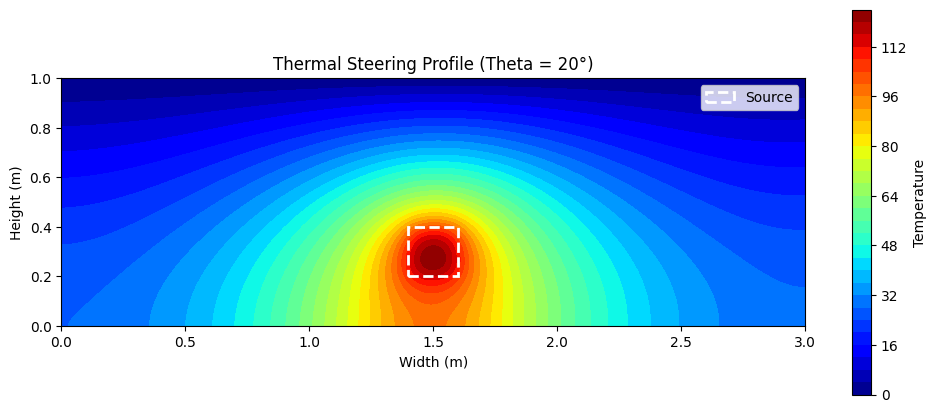

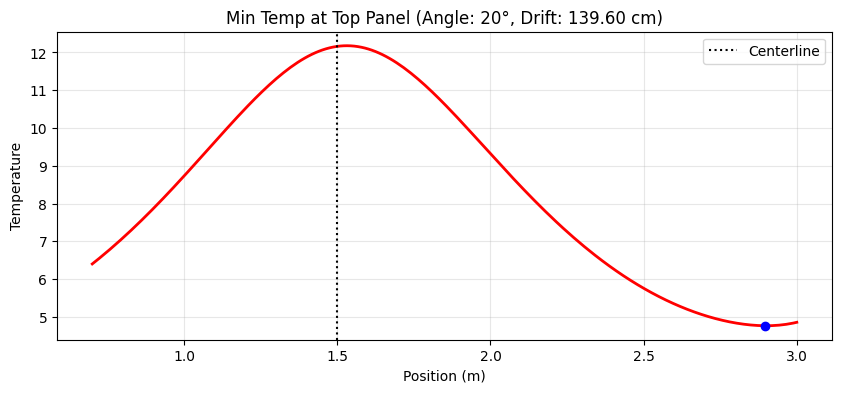

Angle 20° Result: Min T: 4.77, Drift: 139.60 cm
------------------------------
--- Running Simulation for Angle: 30° ---
Solving linear variational problem.


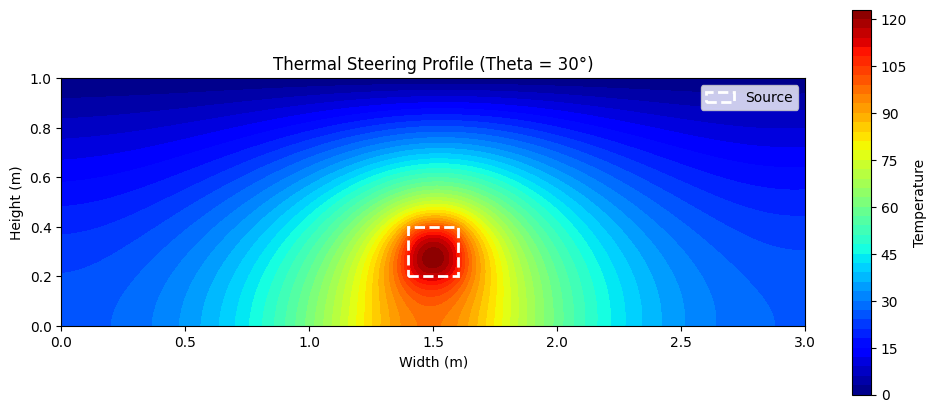

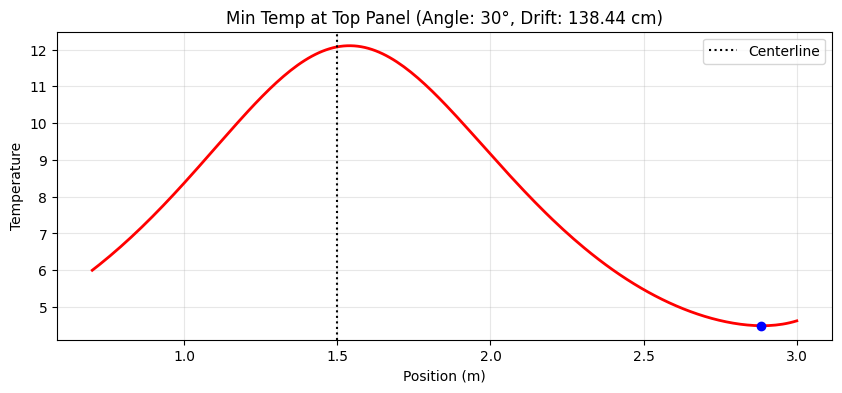

Angle 30° Result: Min T: 4.49, Drift: 138.44 cm
------------------------------
--- Running Simulation for Angle: 40° ---
Solving linear variational problem.


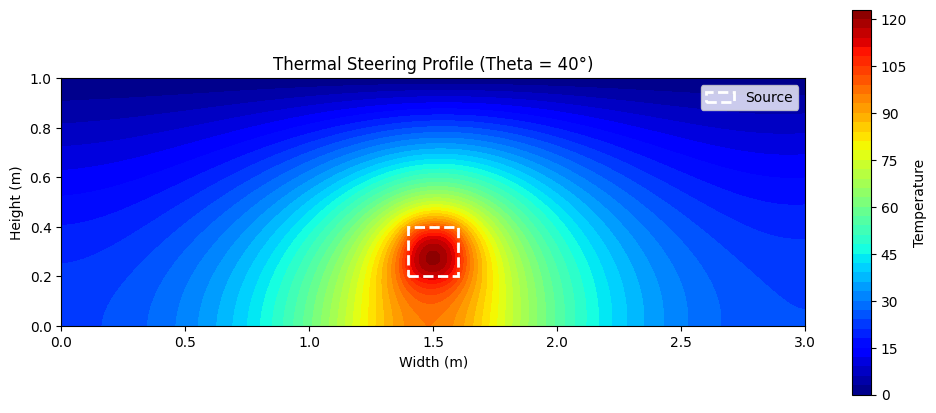

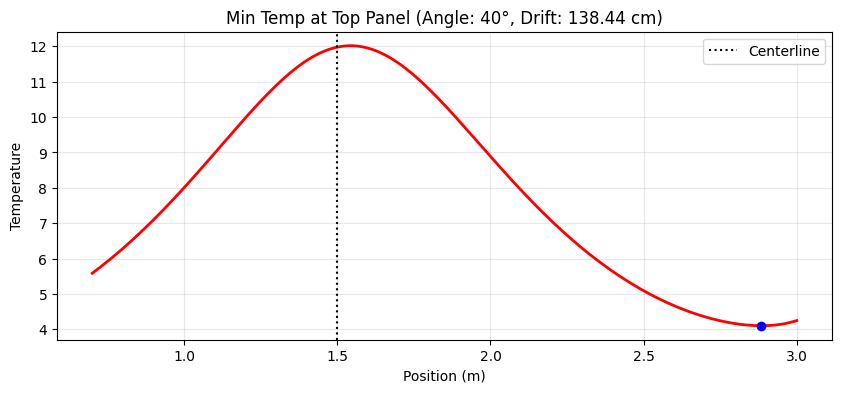

Angle 40° Result: Min T: 4.10, Drift: 138.44 cm
------------------------------
--- Running Simulation for Angle: 50° ---
Solving linear variational problem.


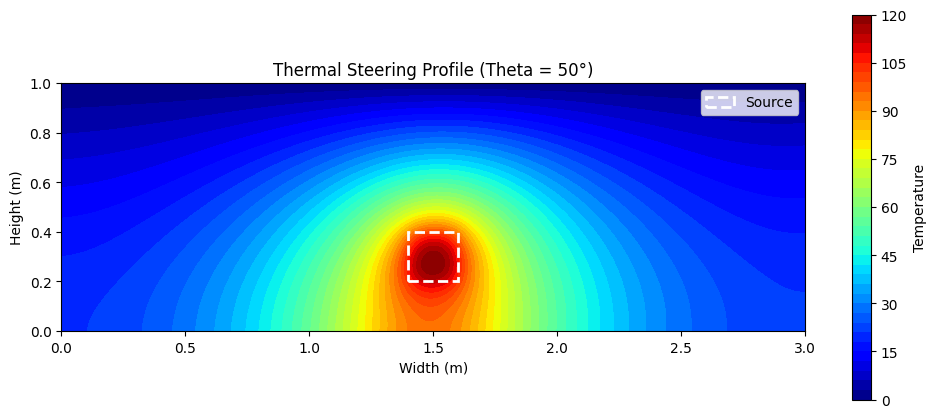

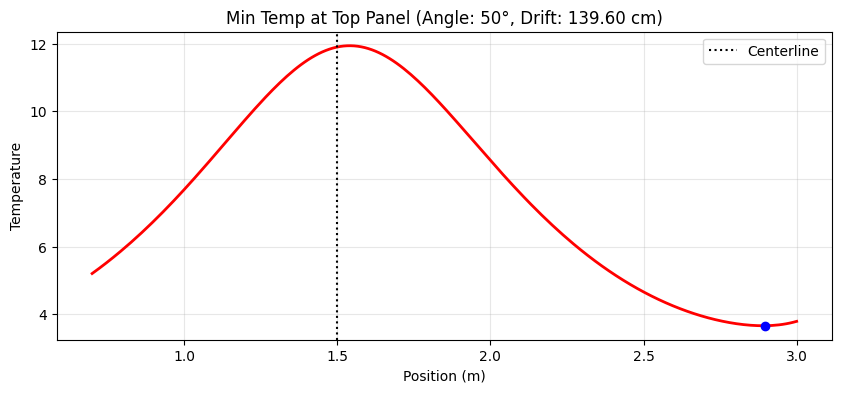

Angle 50° Result: Min T: 3.67, Drift: 139.60 cm
------------------------------
--- Running Simulation for Angle: 60° ---
Solving linear variational problem.


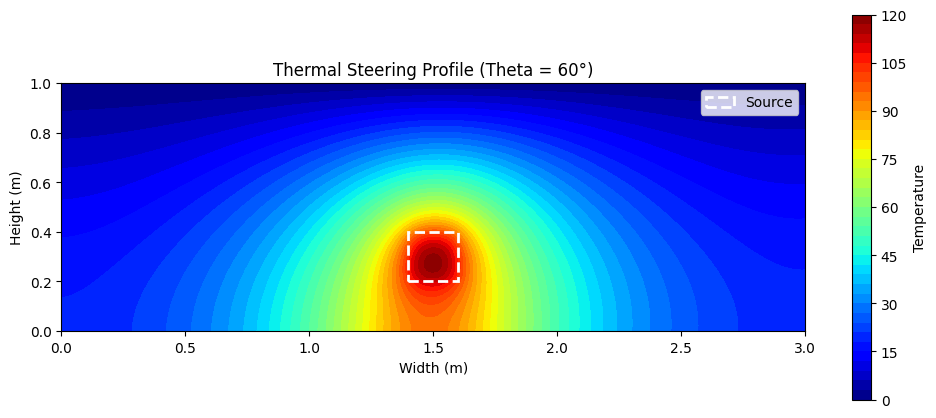

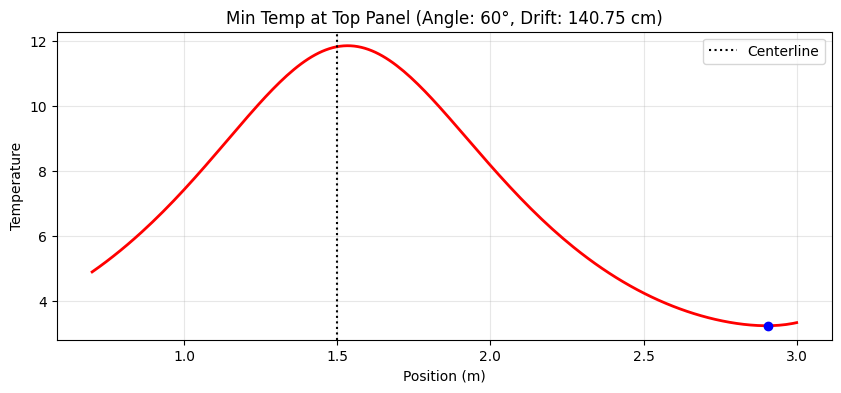

Angle 60° Result: Min T: 3.25, Drift: 140.75 cm
------------------------------
--- Running Simulation for Angle: 70° ---
Solving linear variational problem.


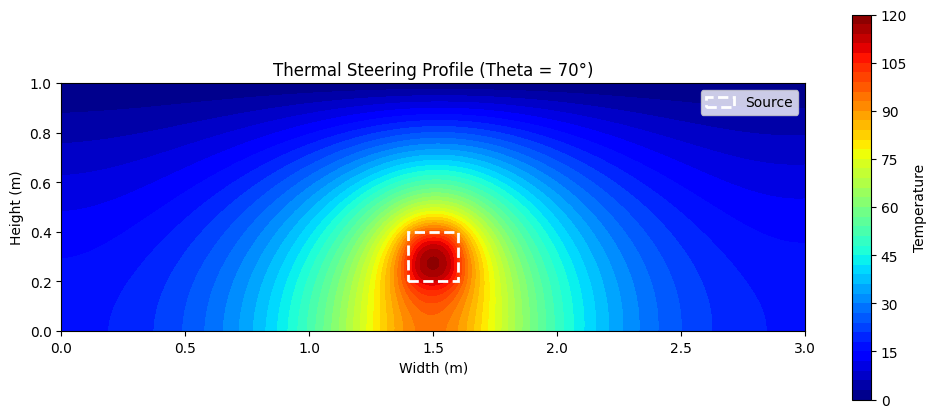

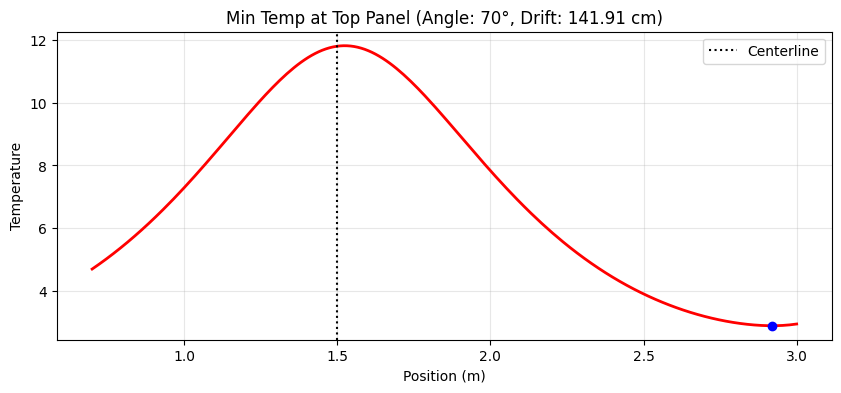

Angle 70° Result: Min T: 2.89, Drift: 141.91 cm
------------------------------
--- Running Simulation for Angle: 80° ---
Solving linear variational problem.


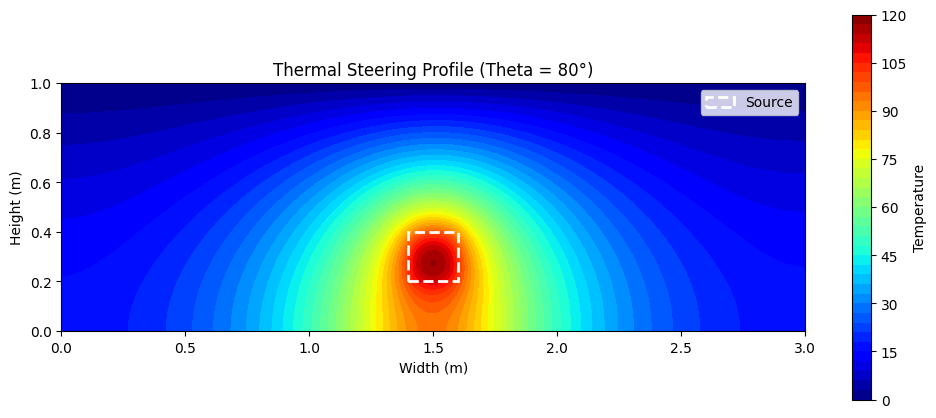

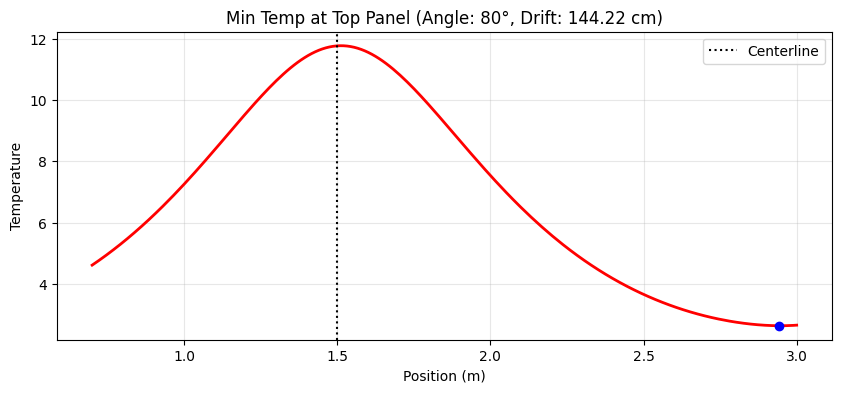

Angle 80° Result: Min T: 2.63, Drift: 144.22 cm
------------------------------
--- Running Simulation for Angle: 90° ---
Solving linear variational problem.


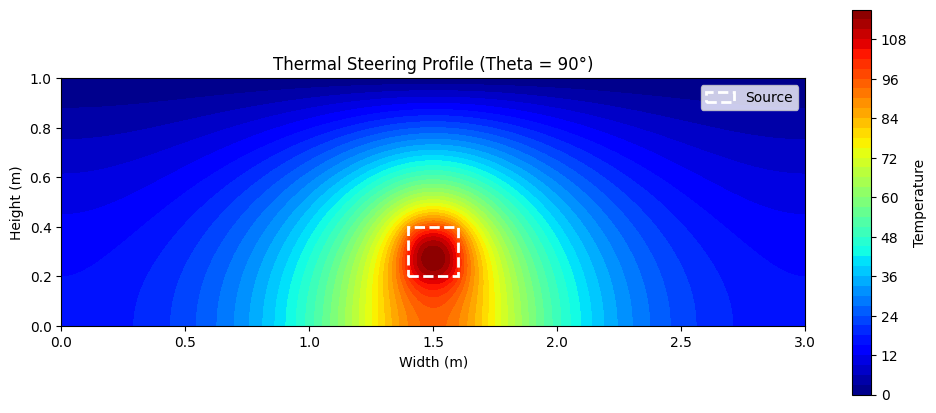

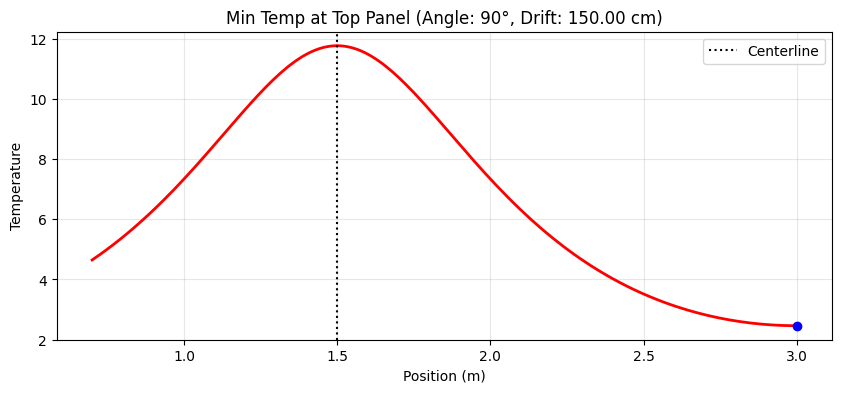

Angle 90° Result: Min T: 2.46, Drift: 150.00 cm
------------------------------


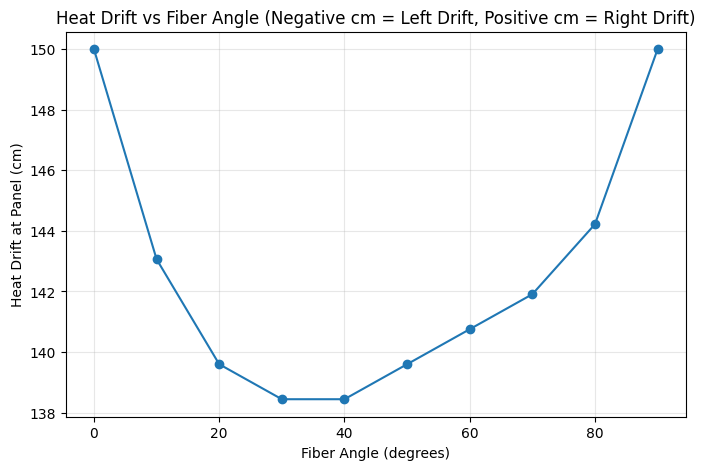

In [10]:
# Load the data from your first notebook
data = np.load("composite_data.npz")
angles = data['angles']
k_xx_list = data['k_xx']
k_xy_list = data['k_xy']
k_yy_list = data['k_yy']
drif_list = []

for th, xx, xy, yy in zip(angles, k_xx_list, k_xy_list, k_yy_list):
    print(f"--- Running Simulation for Angle: {th}° ---")
    
    # SOLVE
    runner = PanelSolver(W=W, H=H, k_xx=xx, k_xy=xy, k_yy=yy, Q=10000)
    solution = runner.solve()
    solution.set_allow_extrapolation(True) 

    # 2D HEATMAP
    plt.figure(figsize=(12, 5))
    p = plot(solution, title=f"Thermal Steering Profile (Theta = {th}°)", cmap="jet")
    plt.colorbar(p, label='Temperature')

    # Draw the Heat Source Square
    plt.gca().add_patch(plt.Rectangle((1.4, 0.2), 0.2, 0.2, 
                                      edgecolor='white', fill=False, lw=2, ls='--', label="Source"))
    plt.xlabel("Width (m)")
    plt.ylabel("Height (m)")
    plt.legend()
    plt.show() 

    # 1D CROSS-SECTION
    x_line = np.linspace(0.7, runner.W, 200)
    temp_line = [solution(x, runner.H*0.90) for x in x_line]
    
    
    min_temp = min(temp_line)            
    min_x = x_line[np.argmin(temp_line)] 
    
    drift = min_x - 1.5
    drif_list.append(drift) 
    
    plt.figure(figsize=(10, 4))
    plt.plot(x_line, temp_line, color='red', linewidth=2)
    plt.axvline(x=1.5, color='black', linestyle=':', label='Centerline')
    plt.scatter(min_x, min_temp, color='blue', zorder=5)
    plt.title(f"Min Temp at Top Panel (Angle: {th}°, Drift: {drift*100:.2f} cm)")
    plt.xlabel("Position (m)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show() 

    print(f"Angle {th}° Result: Min T: {min_temp:.2f}, Drift: {drift*100:.2f} cm")
    print("-" * 30)

# Final Drift Summary
fig=plt.figure(figsize=(8,5))
plt.plot(angles, np.array(drif_list)*100, marker='o')
plt.title("Heat Drift vs Fiber Angle (Negative cm = Left Drift, Positive cm = Right Drift)")
plt.xlabel("Fiber Angle (degrees)")
plt.ylabel("Heat Drift at Panel (cm)")
plt.grid(alpha=0.3)
plt.show()

# Average Temperature Vs Tilting Fibers 


--- Running Simulation for Angle: 0° ---
Solving linear variational problem.


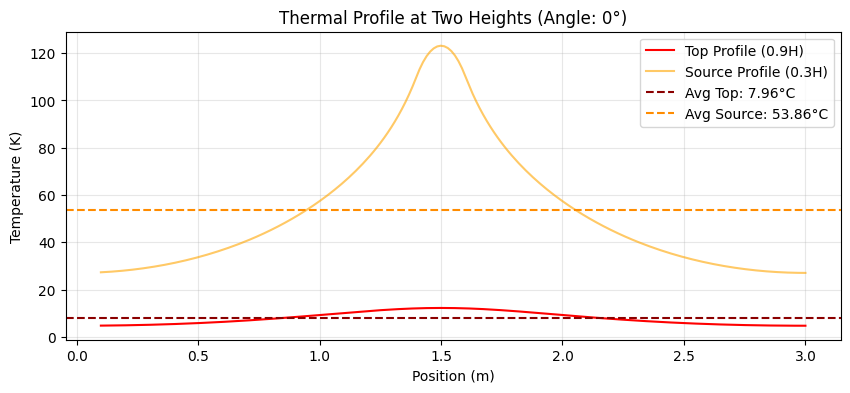

--- Running Simulation for Angle: 10° ---
Solving linear variational problem.


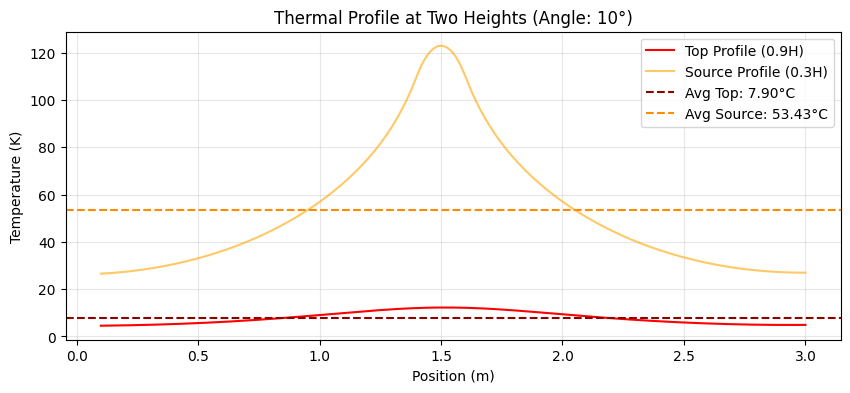

--- Running Simulation for Angle: 20° ---
Solving linear variational problem.


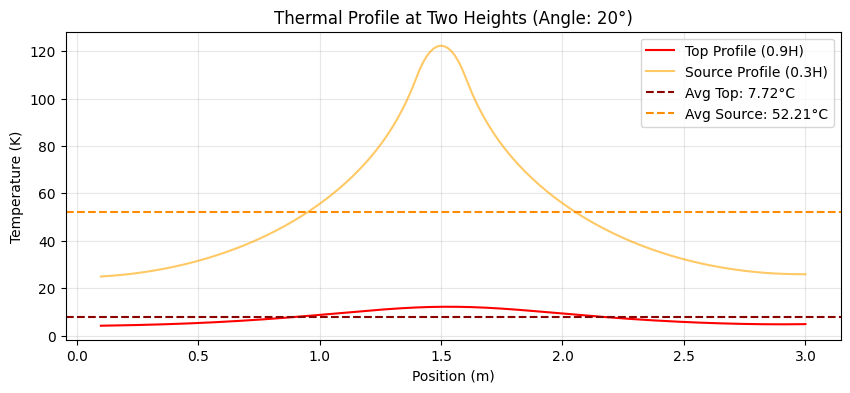

--- Running Simulation for Angle: 30° ---
Solving linear variational problem.


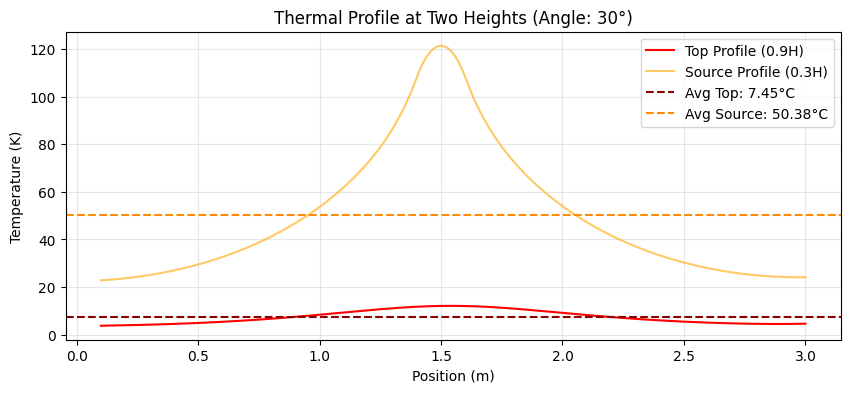

--- Running Simulation for Angle: 40° ---
Solving linear variational problem.


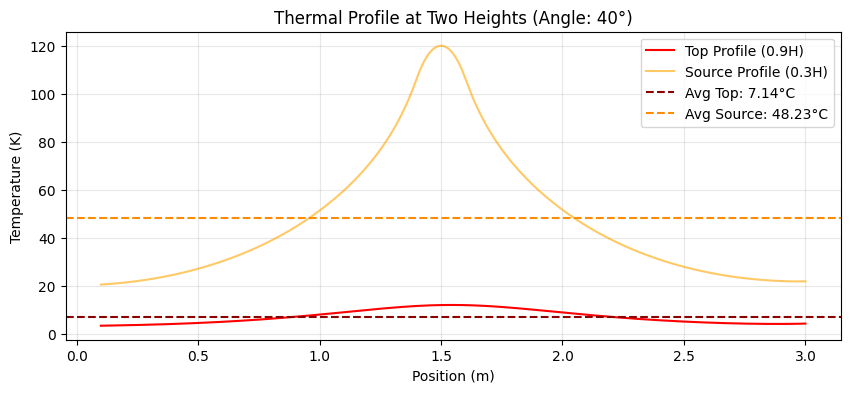

--- Running Simulation for Angle: 50° ---
Solving linear variational problem.


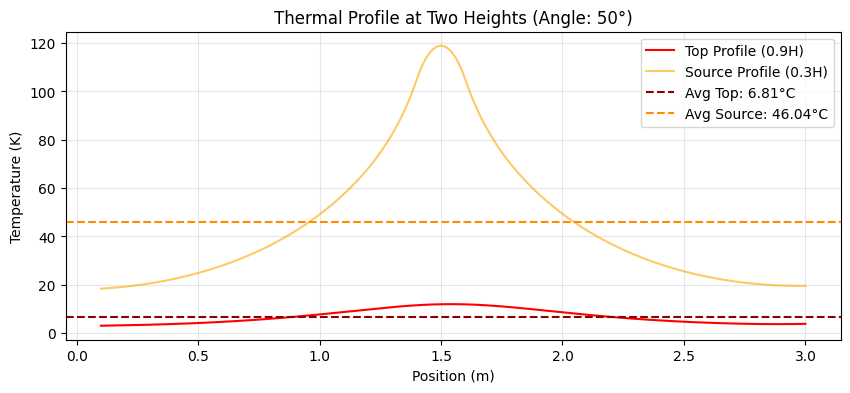

--- Running Simulation for Angle: 60° ---
Solving linear variational problem.


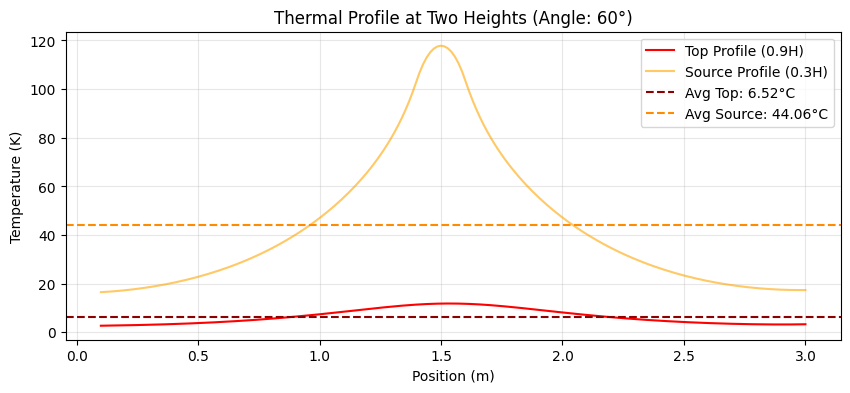

--- Running Simulation for Angle: 70° ---
Solving linear variational problem.


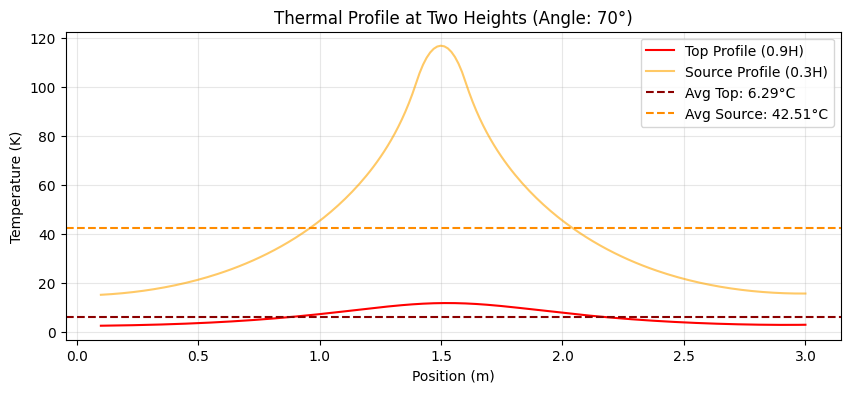

--- Running Simulation for Angle: 80° ---
Solving linear variational problem.


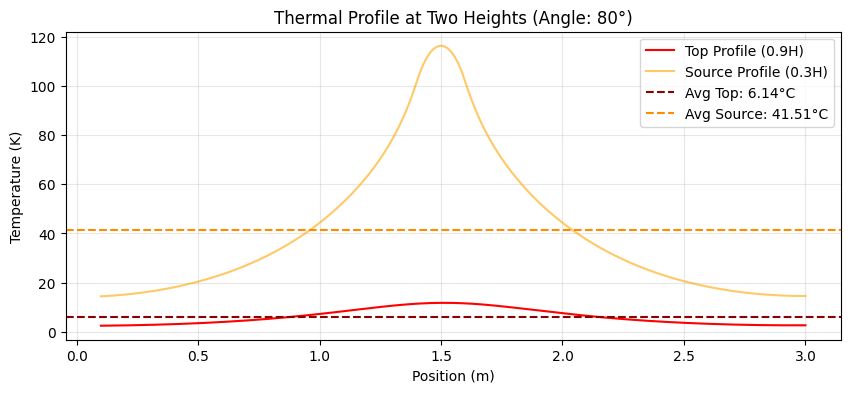

--- Running Simulation for Angle: 90° ---
Solving linear variational problem.


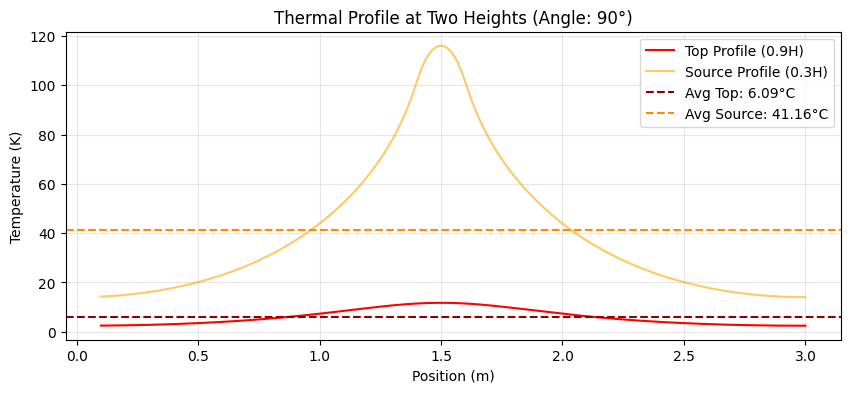

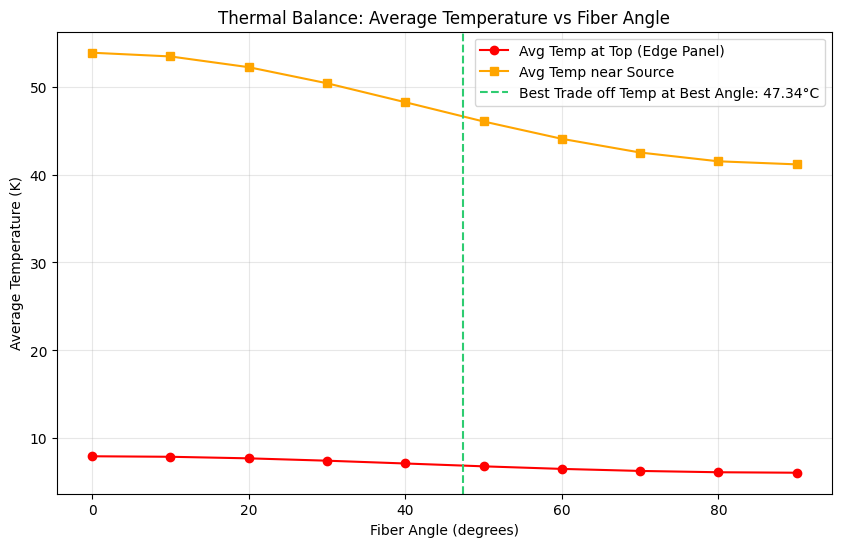

In [32]:
# LOAD DATA
data = np.load("composite_data.npz")
angles = data['angles']
k_xx_list = data['k_xx']
k_xy_list = data['k_xy']
k_yy_list = data['k_yy']

# Result Tracking for Average Temperatures
avg_temp_top = []    # Averages at y = 0.9H (Near top panel)
avg_temp_source = [] # Averages at y = 0.3H (Near Source)

for th, xx, xy, yy in zip(angles, k_xx_list, k_xy_list, k_yy_list):
    print(f"--- Running Simulation for Angle: {th}° ---")
    
    # SOLVE
    runner = PanelSolver(W=W, H=H, k_xx=xx, k_xy=xy, k_yy=yy, Q=10000)
    solution = runner.solve()
    solution.set_allow_extrapolation(True) 

    # 1D CROSS-SECTION SAMPLING
    x_line = np.linspace(0.1, runner.W, 200)
    
    # Recover temperature arrays for both heights
    temp_line_top = [solution(x, runner.H*0.90) for x in x_line]
    temp_line_bot = [solution(x, runner.H*0.30) for x in x_line]
    
    # CALCULATE AVERAGES
    avg_top = np.mean(temp_line_top)
    avg_bot = np.mean(temp_line_bot)
    
    avg_temp_top.append(avg_top)
    avg_temp_source.append(avg_bot)
    
    # 1D DIAGNOSTIC PLOT
    plt.figure(figsize=(10, 4))
    plt.plot(x_line, temp_line_top, color='red', label='Top Profile (0.9H)')
    plt.plot(x_line, temp_line_bot, color='orange', label='Source Profile (0.3H)', alpha=0.6)
    
    # Draw Average Horizontal Lines
    plt.axhline(y=avg_top, color='darkred', linestyle='--', label=f'Avg Top: {avg_top:.2f}°C')
    plt.axhline(y=avg_bot, color='darkorange', linestyle='--', label=f'Avg Source: {avg_bot:.2f}°C')
    
    plt.title(f"Thermal Profile at Two Heights (Angle: {th}°)")
    plt.xlabel("Position (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 2. FINAL BALANCE SUMMARY
plt.figure(figsize=(10, 6))
plt.plot(angles, avg_temp_top, marker='o', color='red', label='Avg Temp at Top (Edge Panel)')
plt.plot(angles, avg_temp_source, marker='s', color='orange', label='Avg Temp near Source')
plt.axvline(x=np.mean(avg_temp_source), color='#2ECC71', linestyle='--', label=f'Best Trade off Temp at Best Angle: {np.mean(avg_temp_source):.2f}°C')
plt.title("Thermal Balance: Average Temperature vs Fiber Angle")
plt.xlabel("Fiber Angle (degrees)")
plt.ylabel("Average Temperature (K)")
plt.legend()
#plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()